In [1]:
import os
from tensorflow.python.client import device_lib

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
# ...existing code...

# Define the base directory relative to the notebook's location
base_dir = os.getcwd()  # Gets the current working directory
data_dir = os.path.join(base_dir, '..', 'data')
models_dir = os.path.join(base_dir, '..', 'models')

# Update paths to be relative
train_data_dir = os.path.join(data_dir, 'train')
val_data_dir = os.path.join(data_dir, 'val')
model_path = os.path.join(models_dir, 'best_cnn.h5')
old_model_path = os.path.join(models_dir, 'best_cnn_old.h5')
csv_path = os.path.join(models_dir, 'labels_cnn.csv')

# Ensure directories exist
for directory in [train_data_dir, val_data_dir, models_dir]:
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f'Directory created: {directory}')
    else:
        print(f'Directory already exists: {directory}')

# Update the rest of the code to use these relative paths
# Example usage:
# train_generator = train_datagen.flow_from_directory(train_data_dir, ...)
# val_generator = val_datagen.flow_from_directory(val_data_dir, ...)
# model = load_model(model_path) if os.path.exists(model_path) else build_model()
# labels_df.to_csv(csv_path, index=False)

Directory already exists: c:\Users\MOS\Koen\Wondherkenning\Wound-Classification-DL\src\..\data\train
Directory already exists: c:\Users\MOS\Koen\Wondherkenning\Wound-Classification-DL\src\..\data\val
Directory already exists: c:\Users\MOS\Koen\Wondherkenning\Wound-Classification-DL\src\..\models


In [3]:
print('TensorFlow version:', tf.__version__)
print('Is TensorFlow built with GPU support?', tf.test.is_built_with_cuda())

TensorFlow version: 2.10.0
Is TensorFlow built with GPU support? True


In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print('Available GPUs:', gpus)
else:
    print('No GPUs found. Please check your GPU setup.')

No GPUs found. Please check your GPU setup.


In [5]:
for device in device_lib.list_local_devices():
    if device.device_type == 'GPU':
        print(device.physical_device_desc)
        break

In [6]:
# train_data_dir = r'E:\Projects\Wound-Classification-DL\data\train'
# val_data_dir = r'E:\Projects\Wound-Classification-DL\data\val'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

Found 9611 images belonging to 10 classes.
Found 3611 images belonging to 10 classes.


In [7]:
def build_model():
    model = Sequential([
        Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(256, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        GlobalAveragePooling2D(),
        Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(train_generator.num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# model_path = r'E:\Projects\Wound-Classification-DL\models\best_cnn.h5'

if os.path.exists(model_path):
    print(f'Loading model')
    model = load_model(model_path)
else:
    print('No saved model found. Building a new model...')
    model = build_model()

model.summary()

Loading model
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 64)      1792      
                                                                 
 batch_normalization_3 (Batc  (None, 126, 126, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 63, 63, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 128)       73856     
                                                                 
 batch_normalization_4 (Batc  (None, 61, 61, 128)      512       
 hNormalization)                                                 
                                        

In [8]:
checkpoint_callback = ModelCheckpoint(
    filepath=model_path,        
    monitor='val_accuracy',          
    save_best_only=True,             
    mode='max',                      
    verbose=0                       
)

early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',         
    patience=10,                      
    mode='max',                     
    restore_best_weights=True,       
    verbose=1                        
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',       
    factor=0.5,               
    patience=3,               
    min_lr=1e-6,              
    verbose=1                 
)

history = model.fit(
    train_generator,
    epochs=100,
    verbose=1,
    validation_data=val_generator,
    callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr]
)

Epoch 1/100
301/301 [==============================] - 278s 920ms/step - loss: 0.1498 - accuracy: 0.9727 - val_loss: 0.0875 - val_accuracy: 0.9909 - lr: 3.1250e-05
Epoch 2/100
301/301 [==============================] - 256s 852ms/step - loss: 0.1442 - accuracy: 0.9743 - val_loss: 0.0850 - val_accuracy: 0.9906 - lr: 3.1250e-05
Epoch 3/100
301/301 [==============================] - 256s 849ms/step - loss: 0.1453 - accuracy: 0.9739 - val_loss: 0.0869 - val_accuracy: 0.9911 - lr: 3.1250e-05
Epoch 4/100
301/301 [==============================] - 256s 850ms/step - loss: 0.1422 - accuracy: 0.9764 - val_loss: 0.0820 - val_accuracy: 0.9934 - lr: 3.1250e-05
Epoch 5/100
 24/301 [=>............................] - ETA: 3:48 - loss: 0.1574 - accuracy: 0.9688

KeyboardInterrupt: 

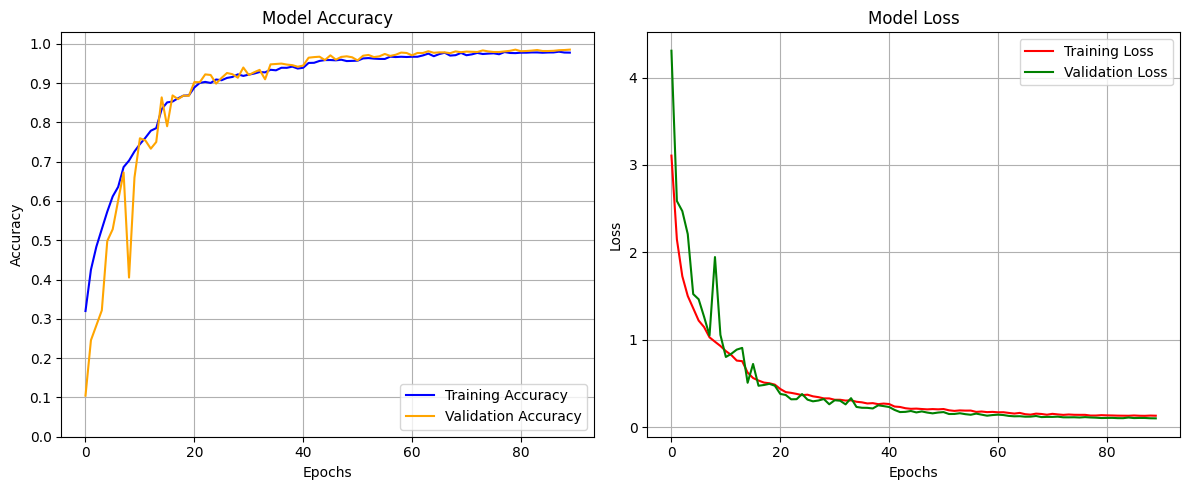

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(history.history['accuracy'], label='Training Accuracy', color='blue', linestyle='-')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange', linestyle='-')
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].set_yticks(np.arange(0, 1.1, 0.1))
axes[0].legend()
axes[0].grid(True)

axes[1].plot(history.history['loss'], label='Training Loss', color='red', linestyle='-')
axes[1].plot(history.history['val_loss'], label='Validation Loss', color='green', linestyle='-')
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
loss, accuracy = model.evaluate(val_generator)
print(f'Validation Loss: {loss:.4f}')
print(f'Validation Accuracy: {accuracy:.2%}')

63/63 [==============================] - 1s 18ms/step - loss: 0.1061 - accuracy: 0.9850
Validation Loss: 0.1061
Validation Accuracy: 98.50%


In [ ]:
# old_model_path = r'E:\Projects\Wound-Classification-DL\models\best_cnn_old.h5'
old_model = load_model(old_model_path)
old_loss, old_accuracy = old_model.evaluate(val_generator)
print(f'Old Validation Loss: {old_loss:.4f}')
print(f'Old Validation Accuracy: {old_accuracy:.2%}')

63/63 [==============================] - 33s 319ms/step - loss: 0.4103 - accuracy: 0.8980
Old Validation Loss: 0.4103
Old Validation Accuracy: 89.80%


In [ ]:
labels = train_generator.class_indices

label_list = list(labels.keys())

print('Labels:', label_list)

Labels: ['Abrasions', 'Bruises', 'Burns', 'Cut', 'Diabetic Wounds', 'Laseration', 'Normal', 'Pressure Wounds', 'Surgical Wounds', 'Venous Wounds']


In [ ]:
labels_df = pd.DataFrame(list(labels.items()), columns=['Class', 'Index'])

# csv_path = r'E:\Projects\Wound-Classification-DL\models\labels_cnn.csv'
labels_df.to_csv(csv_path, index=False)

labels_df

,Class,Index
0,Abrasions,0
1,Bruises,1
2,Burns,2
3,Cut,3
4,Diabetic Wounds,4
5,Laseration,5
6,Normal,6
7,Pressure Wounds,7
8,Surgical Wounds,8
9,Venous Wounds,9
